# HbA1c Outcomes Following Automated Insulin Delivery: Exploratory Analysis of the iLet Bionic Pancreas Trial

## 1. Project Overview

This project analyzes data from the Insulin-Only Bionic Pancreas (iLet) Pivotal Trial to examine changes in glycemic control following treatment initiation. The analysis focuses on changes in HbA1c between baseline and the final study visit and compares the outcomes between participants using the iLet Bionic Pancreas and those using other insulin delivery systems.

The objective of this project is analytical rather than clinical. The goal is to demonstrate data preparation, integration of multiple clinical tables, and comparative analysis using patient-level trial data. Results are descriptive and do not attempt to reproduce or replace the findings of the original clinical study.

Secondary analyses explore whether demographic or device-related characteristics, such as diagnosis age or prior continuous glucose monitor (CGM) use, are associated with differences in observed HbA1c change. 

## 2. Data Sources

This analysis integrates multiple tables from the Insulin-Only Bionic Pancreas (iLet) Pivotal Trial dataset:
        - Screening table: demographic information (diagnosis age, sex, CGM use)
        - Local HbA1c table: baseline HbA1c measurements
        - Sample Results table: laboratory results across study visits
        - Treatment table: insulin pump assignment

Each table is linked using a common patient identifier (PtID)

In [1]:
import pandas as pd

In [2]:
def load_tables():
    demo = pd.read_csv("../data/IOBP2DiabScreening.txt", sep="|")
    pre_a1c = pd.read_csv("../data/IOBP2DiabLocalHbA1c.txt", sep="|")
    post_a1c = pd.read_csv("../data/STASampleResults.txt", sep="|")
    treatment = pd.read_csv("../data/IOBP2DiabTreatment.txt", sep="|")
    return demo, pre_a1c, post_a1c, treatment   

In [3]:
demo, pre_a1c, post_a1c, treatment = load_tables()

## 3. Data Preparation

This section combines participant demographic information and HbA1c measurements into a single analysis dataset for outcome comparison. 

In [4]:
# Filter post_a1c

post_a1c_filtered = post_a1c[(post_a1c["ResultName"] == "GLYHB") & (post_a1c["Visit"] == "Week 13")]

# Remove duplicates
post_a1c_final = post_a1c_filtered.sort_values("PtID").drop_duplicates("PtID", keep="last")

# Column selection
demo = demo[["PtID", "DiagAge", "Sex", "CGMUseDevice"]]

pre_a1c = pre_a1c[["PtID", "HbA1cTestRes"]].rename(columns={"HbA1cTestRes": "baseline_hba1c"})

post_a1c_final = post_a1c_final[["PtID", "Value"]].rename(columns={"Value": "post_hba1c"})

treatment = treatment[["PtID", "PumpType"]].drop_duplicates(subset="PtID")

# Merge
df = demo.merge(pre_a1c, on="PtID", how="inner")
df = df.merge(post_a1c_final, on="PtID", how="inner")
df = df.merge(treatment, on="PtID", how="inner")

# Type conversion
df["baseline_hba1c"] = pd.to_numeric(df["baseline_hba1c"], errors="coerce")
df["post_hba1c"] = pd.to_numeric(df["post_hba1c"], errors="coerce")

df.head()

,PtID,DiagAge,Sex,CGMUseDevice,baseline_hba1c,post_hba1c,PumpType
0,183,10,M,Dexcom,NaN,7.5,Other
1,181,9,F,Dexcom,NaN,7.3,Beta Bionics Gen 4 iLet
2,459,7,F,Dexcom,6.5,6.3,Beta Bionics Gen 4 iLet
3,577,46,M,Dexcom,10.2,8.5,Beta Bionics Gen 4 iLet
4,46,13,M,Dexcom,5.7,6.2,NaN


In [5]:
# Data validation

print(f"Rows: {len(df)}")
print(f"Unique patients: {df['PtID'].nunique()}")

Rows: 171
Unique patients: 171


## 4. Exploratory Analysis

HbA1c change is calculated as the difference between Week 13 HbA1c and baseline HbA1c. Negative values represent improvement. 

In [6]:
df["hba1c_change"] = df["post_hba1c"] - df["baseline_hba1c"]

In [7]:
df["hba1c_change"].describe()

count    99.000000
mean     -0.282828
std       0.797706
min      -2.700000
25%      -0.700000
50%      -0.300000
75%       0.300000
max       1.300000
Name: hba1c_change, dtype: float64

Summary statistics are examined to verify reasonable HbA1c ranges and confirm that calculated change values are consistent with expected clinical ranges prior to group comparison. 

## 5. Statistical Comparison

### 5.1 HbA1c Change by Treatment Group

In [8]:
df["PumpType"].value_counts()

PumpType
Beta Bionics Gen 4 iLet                      59
Tandem t:slim X2 with Control:IQ             17
Insulet OmniPod Insulin Management System    16
Medtronic 670G                               14
Other                                         6
Tandem t:slim X2 with Basal:IQ                5
Tandem t:slim                                 5
Tandem t:slim X2                              3
Medtronic 630G                                1
Medtronic Paradigm 512                        1
Medtronic 640G                                1
Medtronic 551 (530G)                          1
MiniMed 770G                                  1
Name: count, dtype: int64

Treatment groups are examined to confirm expected group sizes and ensure no unintended categories are present prior to comparison.

In [9]:
df.groupby("PumpType")["baseline_hba1c"].describe()

,count,mean,std,min,25%,50%,75%,max
PumpType,,,,,,,,
Beta Bionics Gen 4 iLet,38.0,7.607895,1.093811,5.9,6.900,7.45,7.975,10.5
Insulet OmniPod Insulin Management System,10.0,7.280000,1.126252,5.7,6.450,7.25,8.075,9.0
Medtronic 551 (530G),1.0,8.400000,NaN,8.4,8.400,8.40,8.400,8.4
Medtronic 630G,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Medtronic 640G,1.0,7.900000,NaN,7.9,7.900,7.90,7.900,7.9
Medtronic 670G,10.0,7.750000,1.203929,5.4,7.200,7.60,8.150,9.8
Medtronic Paradigm 512,1.0,7.800000,NaN,7.8,7.800,7.80,7.800,7.8
MiniMed 770G,1.0,8.200000,NaN,8.2,8.200,8.20,8.200,8.2
Other,4.0,8.200000,1.512173,7.0,7.375,7.70,8.525,10.4


Baseline HbA1c values are compared across treatment groups to assess whether groups begin the study at comparable levels of glycemic control.

In [10]:
df.groupby("PumpType")["hba1c_change"].describe()

,count,mean,std,min,25%,50%,75%,max
PumpType,,,,,,,,
Beta Bionics Gen 4 iLet,38.0,-0.528947,0.834366,-2.7,-0.875,-0.40,-0.200,1.0
Insulet OmniPod Insulin Management System,10.0,-0.080000,0.434102,-0.6,-0.375,-0.15,0.000,0.7
Medtronic 551 (530G),1.0,0.500000,NaN,0.5,0.500,0.50,0.500,0.5
Medtronic 630G,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Medtronic 640G,1.0,-0.700000,NaN,-0.7,-0.700,-0.70,-0.700,-0.7
Medtronic 670G,10.0,-0.170000,0.881980,-2.0,-0.725,0.10,0.375,0.9
Medtronic Paradigm 512,1.0,0.700000,NaN,0.7,0.700,0.70,0.700,0.7
MiniMed 770G,1.0,-0.500000,NaN,-0.5,-0.500,-0.50,-0.500,-0.5
Other,4.0,-0.250000,0.550757,-0.8,-0.650,-0.30,0.100,0.4


Mean HbA1c change is compared across treatment groups. Negative values represent improvement. 

In [11]:
# Collapse insulin pump types into two categories: "iLet" and "Other"

df["treatment_group"] = df["PumpType"].apply(lambda x: "iLet" if "ilet" in str(x).lower() else "Other")

df["treatment_group"].value_counts()

treatment_group
Other    112
iLet      59
Name: count, dtype: int64

In [12]:
df[df["treatment_group"] == "iLet"]["hba1c_change"].describe()

count    38.000000
mean     -0.528947
std       0.834366
min      -2.700000
25%      -0.875000
50%      -0.400000
75%      -0.200000
max       1.000000
Name: hba1c_change, dtype: float64

In [13]:
df[df["treatment_group"] == "Other"]["hba1c_change"].describe()

count    61.000000
mean     -0.129508
std       0.740123
min      -2.000000
25%      -0.600000
50%      -0.100000
75%       0.500000
max       1.300000
Name: hba1c_change, dtype: float64

<Figure size 640x480 with 0 Axes>

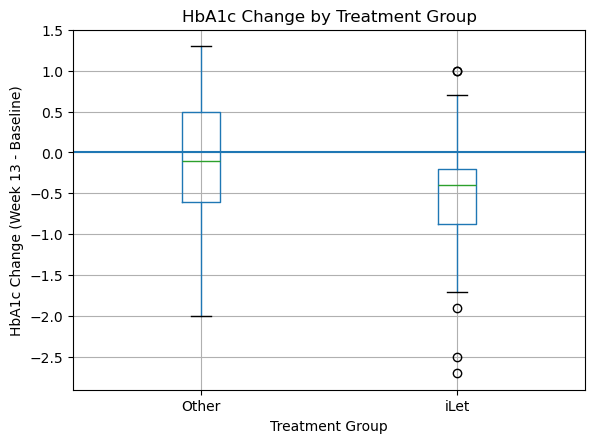

In [14]:
import matplotlib.pyplot as plt

plt.figure()

df.boxplot(column="hba1c_change", by="treatment_group")

plt.axhline(0)
plt.title("HbA1c Change by Treatment Group")
plt.suptitle("")
plt.ylabel("HbA1c Change (Week 13 - Baseline)")
plt.xlabel("Treatment Group")

plt.show()

The comparative analysis indicates that the iLet group demonstrates a lower mean value than the Other group, suggesting a greater overall reduction in the measured outcome. Although variability is slightly higher within the iLet group, as reflected by the larger standard deviation, the difference in mean values suggests a consistent directional effect rather than isolated extreme observations. This result supports the interpretation that outcomes associated with the iLet group tend to be more negative on average, indicating stronger change relative to the comparison group. However, the overall lap in variability between groups suggests that individual outcomes remain heterogeneous, and therefore conclusions should be interpreted in the context of overall trends rather than uniform individual responses. 

### 5.2 HbA1c Change by Diagnosis Age

In [15]:
df["diag_age_group"] = pd.cut(df["DiagAge"], bins=[0, 10, 18, 40, 100], labels=["Childhood", "Adolescent", "Young Adult", "Adult"])

<Figure size 640x480 with 0 Axes>

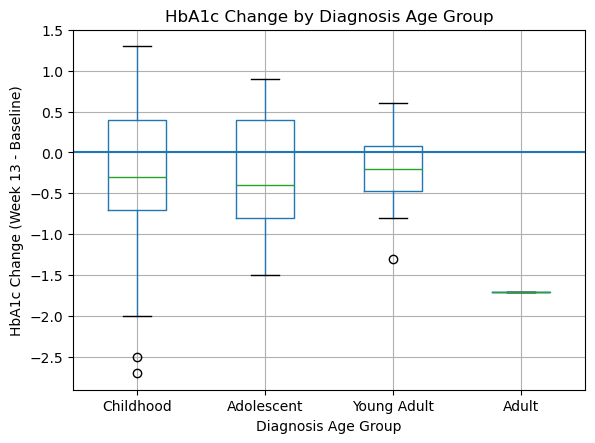

In [16]:
plt.figure()

df.boxplot(column="hba1c_change", by="diag_age_group")

plt.axhline(0)
plt.title("HbA1c Change by Diagnosis Age Group")
plt.suptitle("")
plt.ylabel("HbA1c Change (Week 13 - Baseline)")
plt.xlabel("Diagnosis Age Group")

plt.show()

The distribution of HbA1c change across diagnosis age groups demonstrates variability in treatment response depending on the age at which diabetes was diagnosed. Participants diagnosed during childhood and adolescence exhibit wider variability in HbA1c change, including both substantial reductions and isolated increases. In contrast, individuals diagnosed during young adulthood demonstrate a narrower distribution with more moderate reductions. The adult diagnosis group appears limited in sample size, as reflected by the compressed distribution, and therefore interpretation for this category should be made cautiously. 

Overall, the figure suggests that while improvement in HbA1c was observed across most diagnosis age groups, the magnitude and variability of response may differ by age at diagnosis. However, this analysis remains descriptive and does not account for potential confounding factors such as baseline HbA1c, treatment assignment, or other clinical characteristics that may influence outcomes. 

## 6. Discussion and Interpretation

The statistical analysis presented in the previous section indicates meaningful differences between groups, warranting interpretation in the context of practical outcomes and study limitations. 

In [17]:
from scipy.stats import ttest_ind

ilet = df[df["treatment_group"] == "iLet"]["hba1c_change"]
other = df[df["treatment_group"] == "Other"]["hba1c_change"]

ttest_ind(ilet, other, nan_policy="omit")

TtestResult(statistic=np.float64(-2.4861884839302952), pvalue=np.float64(0.01462134465173554), df=np.float64(97.0))

To support visual comparisons, a two-sample t-test is used to compare mean HbA1c change between treatment groups. This test is included for exploratory purposes only and does not attempt to reproduce or validate the formal statistical analysis in the original clincial trial. 

With a p-value of 0.015, the results suggest a statistically significant difference mean HbA1c change between participants in the iLet treatment group and those using other insulin delivery systems. This finding should be interpreted as evidence of an observed difference within this analytical dataset rather than confirmation of clinical effectiveness.  

Consistent with the statistical results, the boxplot visualization demonstrates that HbA1c changes in the iLet treatment group tended to be more negative on average than those observed in the comparison group. The distribution also shows that most participants in the iLet group experienced reductions in HbA1c, with only a small number exhibiting increases during the study period. 

Because HbA1c reflects average blood glucose levels over approximately two to three months, negative changes in HbA1c correspond to improved glycemic control over time. Within the context of this exploratory analysis, the larger negative mean change in the iLet group suggests greater improvement in glycemic control during the study period, while recognizing that individual responses varied and that causal conclusions cannot be drawn from this analysis alone.

Secondary exploratory analysis suggests that variability in HbA1c change may also differ by age at diagnosis, although these findings are descriptive and require cautious interpretation due to subgroup size differences and lack of covariate adjustment. 

## 7. Limitations and Future Directions

Firstly, differences in participants' baseline HbA1c values were not adjusted for throughout this analysis. Individuals beginning the study with relatively lower HbA1c values have less opportunity for large absolute improvement compared with participants presenting with substantially elevated baseline levels. As a result, comparisons relied on raw HbA1c change without normalization for baseline glycemic control, which may influence interpretation of group differences. 

Additionally, the interval between baseline and final HbA1c assessment was approximately 13 weeks. Although sufficient to observe short-term changes in glycemic control, this duration limits conclusions regarding the durability and long-term stability of treatment effects. 

Furthermore, treatment group comparisons were conducted without reconstruction of the trial's original randomization or adjustment for potential allocation factors. Consequently, observed differences between insulin delivery systems may partially reflect underlying participant characteristics rather than treatment effects alone.

Lastly, several subgroup comparisons were affected by unequal sample sizes. Certain insulin pump systems were represented by only a small number of participants, and the adult diagnosis age group contained markedly fewer individuals than other categories. These imbalances reduce statistical stability and warrant cautious interpretation of subgroup findings. In addition, potential laboratory variability and missing or imprecise measurements may introduce further uncertainty in observed HbA1c values.

The presentation of the raw data itself also created limitations for this analysis. Because data were distributed across multiple bar(|)-separated tables, analysis required merging several clinical datasets to obtain relevant variables. Additonally, HbA1c measurements represented only one of multiple laboratory assessments conducted at week 6, week 13, and an unscheduled (random) assessment visit, requiring filtering and deduplication of participants and lab results. 

The presentation of baseline HbA1c assessment also raises potential concerns, as values were contained within a local laboratory table. Accepting baseline HbA1c results from third-party clinics may compromised standardized protocol-based collection of these initial measurements. It was also decided to exclude additonal standardized HbA1c assessments beyond week 13, leading to a potential loss of temporal variability in glycemic control. 

The treatment tables further introduced inconsistencies in naming and capitalization across insulin pump systems. Therefore, insulin delivery devices were manually grouped into two categories, iLet and Other. This grouping approach may introduce heterogeneity within the comparison group and limit device-specific interpretation.

Lastly, limited demographic availabiltiy constained opportunities for further secondary analysis. For example, age values represented age at diagnosis rather than age at study enrollment, preventing adjusting for age-related clinical factors. Additional patient history, comorbidities, and clincial covariates were not available, limiting confounder adjustment. 

Future steps for this analysis include improvements in statistical modeling. Baseline-adjusted approaches such as ANCOVA or regression could be implemented to model HbA1c change while controlling for baseline glycemic control. Multivariate modeling incorporating CGM use or diagnosis age, as well as subgroup interaction testing, could further elucidate relationships within the dataset. 

The analytical framework could also be strengthened through incorporation of week 6 HbA1c values to better model longitudinal trajectory. This would enable repeated measures analysis rather than reliance on a single change score and provide insight into variability and stability of glycemic control across participants. 

Improved classification and standardized naming of insulin delivery systems would allow for device-level comparisons beyond the binary grouping performed. Sensitivity analyses using alternative grouping strategies could also assess robustness of findings. 

Future iterations of this project could further strengthen the data engineering workflow supporting the analysis. The current pipeline relies on manual filtering, deduplication, and column selection steps that could be formalized into reusable preprocessing functions. Schema harmonization across clinical tables, automated validation checks for duplicate patient identifiers, and standardized device naming dictionaries would improve reliability and reduce the risk of silent data inconsistencies during table merging. 

Reproducibility could be enhanced through development of a modular analysis pipeline separating data ingestion, preprocessing, feature engineering, and statistical modeling stages. Version-controlled data dictionaries, environment specification files, and deterministic preprocessing procedures would ensure that analytical results can be regenerated consistently across computational environments and future dataset updates. 

From a portfolio perspective, future development of this project may emphasize transparency and methodological clarity rather than clinical inference. Expanding documentation of data integration decisions, inclusion of sensitivity analyses, and presentation of alternative modeling strategies would highlight competencies in clinical data wrangling, exploratory statistical analysis, and reproducible research workflows. These enhancements position the project as a demonstration of practical bioinformatics and clinical data science skills. 

## 8. Conclusion

This exploratory analysis demonstrates that participants using the iLet Bionic Pancreas exhibited larger reductions in HbA1c on average compared with individuals using alternative insulin delivery systems. However, the findings remain descriptive due to baseline variability, limited follow-up duration, and constraints in the available clinical tables. From a methodological perspective, the project highlights practical competencies in clinical data integration, preprocessing, and reproducible exploratory statistical analysis using multi-table trial data. 